### Simulation of Prices of coupon-Bearing Bonds using CIR

In [67]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from risk_kit import Metrics, pre_processing_ind, get_ind30_nfirms, get_ind30_size, plot_ef2
import ipywidgets as widgets
from IPython.display import display

pd.options.display.float_format = '{:.6f}'.format

m = Metrics()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We want to simulate thousands of different portfolio construction techniques on how
to put together a Goal Hedging Portofolio in a Performance Seeking Portfolio. For this purpose we will use the CIR model that generates scenarios for different interest rates.

In [48]:
m.bond_price(5, 100, 0.05, 12, .03)

0   109.275
dtype: float64

In [49]:
# generate rates and ZC Bond prices
rates, zc_prices = m.cir(10, 500, b=0.03, r_0=0.03)

In [50]:
rates[[1,2,3]].head()

,1,2,3
0,0.030,0.030,0.030
1,0.028,0.028,0.029
2,0.033,0.028,0.027
3,0.032,0.029,0.026
4,0.033,0.026,0.029


In [51]:
m.bond_price(5, 100, 0.05, 12, rates.iloc[0][[1,2,3]])

1   109.275
2   109.275
3   109.275
dtype: float64

In [52]:
# let's see the bond prices at time = 1
m.bond_price(5, 100, 0.05, 12, rates.iloc[1][[1,2,3]])

1   110.154
2   110.282
3   109.902
dtype: float64

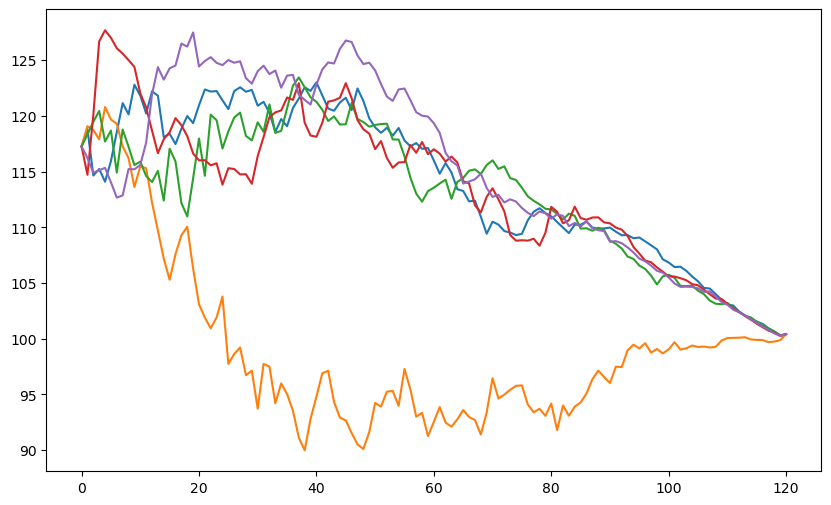

In [53]:
# let's simulate how bond prices changes with interest rates
m.bond_price(10, 100, 0.05, 12, rates[[1, 2, 3, 4, 5]]).plot(legend=False);

In [54]:
prices = m.bond_price(10, 100, 0.05, 12, rates[[1, 2, 3, 4, 5]])
prices

,1,2,3,4,5
0,117.260,117.260,117.260,117.260,117.260
1,118.837,119.085,118.348,114.718,116.231
2,114.653,118.729,119.476,120.077,114.902
3,115.237,117.905,120.445,126.687,115.128
4,114.095,120.802,117.702,127.689,115.344
...,...,...,...,...,...
116,101.333,99.886,101.245,101.041,101.109
117,100.944,99.694,100.915,100.730,100.794
118,100.655,99.752,100.642,100.545,100.481
119,100.299,99.875,100.309,100.270,100.262


In [55]:
# let's compute the bond returns
br = prices.pct_change().dropna()
m.annualized_rets(br, 12)

1   -0.015
2   -0.015
3   -0.015
4   -0.015
5   -0.015
dtype: float64

COMMENT: How is that the annualized returns are negative? It doesn't make any sense
However we are looking only at the prices return instead of total return of the bond (the quantity we are interested in). We forgot to include the coupons of the returns.

In [56]:
p= m.bond_price(10, 100, .05, 12, rates[[1,2,3,4]])
btr = m.bond_total_return(p, 100, .05, 12)
m.annualized_rets(btr, 12)

1   0.029
2   0.036
3   0.029
4   0.029
dtype: object

#### Now we can put everything together: we have got a way to generate prices (from which we can compute return). We can start experimenting across asset classes

In [57]:
# let's consider a 10-year bond
price_10 = m.bond_price(10, 100, 0.05, 12, rates)
price_10[[1,2,3]].tail()

,1,2,3
116,101.333,99.886,101.245
117,100.944,99.694,100.915
118,100.655,99.752,100.642
119,100.299,99.875,100.309
120,100.417,100.417,100.417


In [59]:
# let's consider a 30-year bond after 10 years
price_30 = m.bond_price(30, 100, 0.05, 12, rates)
price_30[[1,2,3]].tail()

,1,2,3
116,173.724,95.717,167.202
117,167.874,85.814,165.076
118,171.448,83.159,169.473
119,162.705,83.159,165.522
120,163.505,77.948,157.904


In [60]:
price_30[[1,2,3]].head()

,1,2,3
0,139.532,139.532,139.532
1,144.015,144.687,142.693
2,133.245,144.016,146.067
3,134.975,142.064,149.101
4,132.242,150.468,141.796


COMMENT: after 10 years there is an enormous variation wrt the starting value. It is so tempting
to think that a bond is safe but it isn't.

In [63]:
# let's construct a portfolio of two bonds. We are assuming a monthly rebalance with the same weights since at
# the end of every month the composition of the two portfolio has changed
rets_10 = m.bond_total_return(price_10, 100, 0.05, 12)
rets_30 = m.bond_total_return(price_30, 100, 0.05, 12)
rets_bonds = .6*rets_10 + .4*rets_30

In [68]:
# let's construct a one time series from 500 time series using the mean of them
mean_rets_bond = rets_bonds.mean(axis="columns")
m.summary_stats(pd.DataFrame(mean_rets_bond))

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
0,0.035862,0.003877,-0.040945,3.105715,-0.001097,-0.000637,1.471598,0.000000


this composite index has no drawdown by definition

In [72]:
# let's generate a portoflio of equities
price_eq = m.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
price_eq.shape

(121, 500)

In [76]:
# we are ok
rets_eq = price_eq.pct_change().dropna()
rets_eq.shape, rets_bonds.shape

((120, 500), (120, 500))

In [77]:
# let's combine the two portfolios
rets = .7*rets_eq + .3*rets_bonds
# let's build a composite (not very accurate)
rets_mean = rets.mean(axis="columns")
m.summary_stats(pd.DataFrame(rets_mean))

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
0,0.059980,0.004455,0.256124,3.035188,-0.002856,-0.002424,6.549578,0.000000


COMMENT: we are able to combine random bonds and random stock prices. We would like to know
how to allocate the weights (called: Fix-Mixes Allocator).
The whole goal is to find the weights given a certain liabilities constraints.